In [2]:
library(Matrix)
library(Seurat)
library(SeuratData)

library(ggplot2)

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Attaching SeuratObject

── Installed datasets ──────────────────────────────────────────────────────────────────────── SeuratData v0.2.2 ──

✔ panc8  3.0.2                                           ✔ pbmc3k 3.1.4


─────────────────────────────────────────────────────── Key ───────────────────────────────────────────────────────

✔ Dataset loaded successfully
❯ Dataset built with a newer version of Seurat than installed
❓ Unknown version of Seurat installed




In [3]:
source("../R/rvp.R")

# panc8 data set
- 8 data sets; 5 technologies
- (34363, 14890)
- Idents: celltype, tech, dataset

In [3]:
panc8

An object of class Seurat 
34363 features across 14890 samples within 1 assay 
Active assay: RNA (34363 features, 0 variable features)

#### QC - Cells

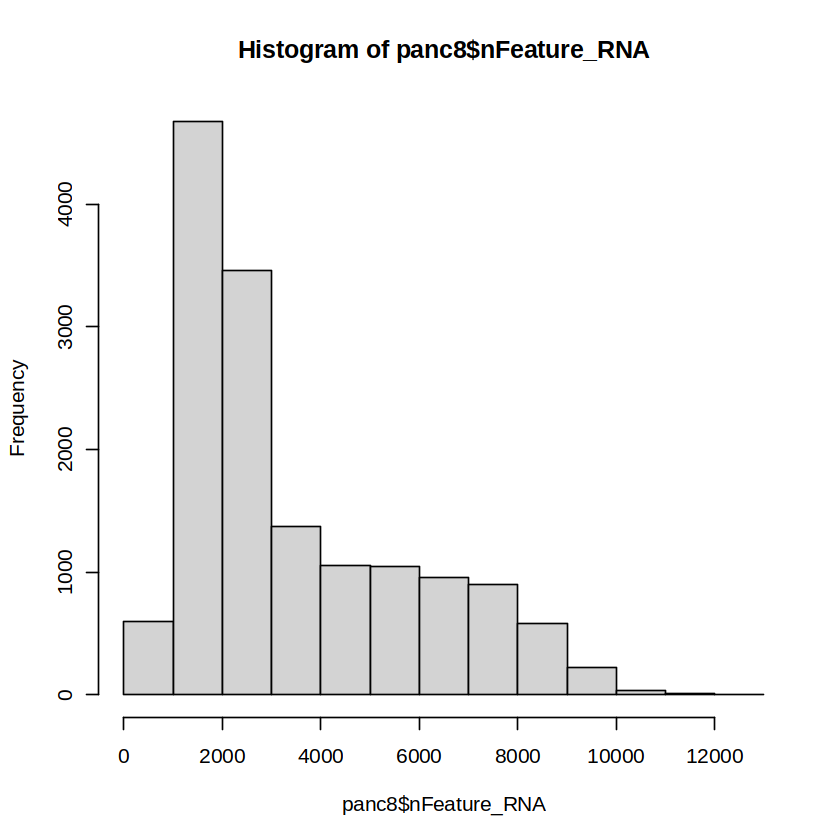

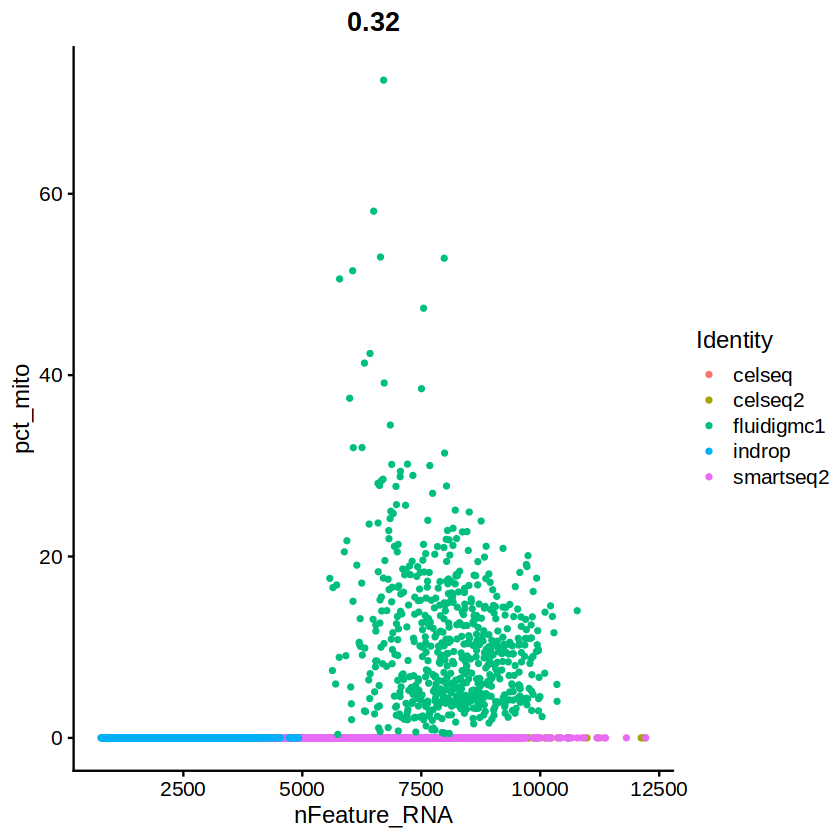

In [4]:
panc8[["pct_mito"]] <- PercentageFeatureSet(panc8, pattern = "^MT-")
hist(panc8$nFeature_RNA)
FeatureScatter(panc8, feature1 = "nFeature_RNA", feature2 = "pct_mito")

indrops <- paste0("indrop", 1:3)
panc8 <- subset(panc8,
  subset = nFeature_RNA > 800 & nFeature_RNA < 10000 &
    pct_mito < 20 & !(panc8$dataset %in% indrops)
)

#### QC - Filter features

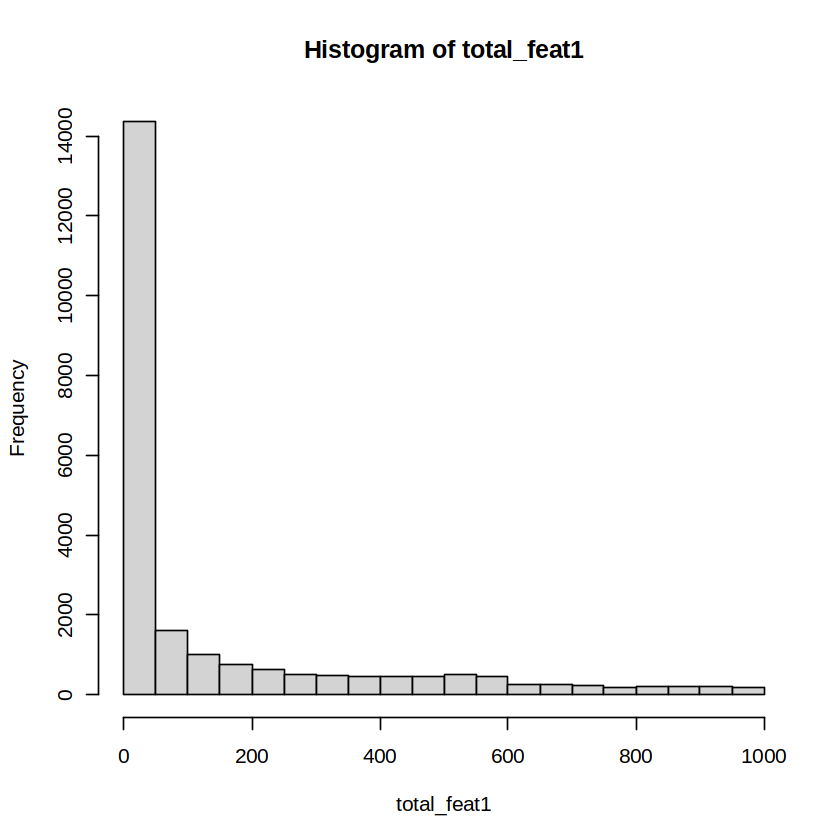

In [5]:
counts <- GetAssayData(panc8, "counts")
total_feat <- rowSums(counts > 0)
total_feat1 <- total_feat[total_feat < 1000]
hist(total_feat1)
# table(panc8$celltype, panc8$tech)

In [6]:
panc8_fltr <- panc8[total_feat > 500, ]

In [9]:
panc8_fltr

An object of class Seurat 
13671 features across 7515 samples within 1 assay 
Active assay: RNA (13671 features, 0 variable features)

#### RVP

In [7]:
rvp <- RVP.Seurat(panc8_fltr, "tech", "celltype", ret.obj = TRUE)

In [19]:
str(rvp)

List of 3
 $ percentage        : num 0.447
 $ percentage_classes: Named num [1:13] 0.331 0.444 0.545 0.445 0.35 ...
  ..- attr(*, "names")= chr [1:13] "acinar" "activated_stellate" "alpha" "beta" ...
 $ sum_squares       :'data.frame':	13671 obs. of  2 variables:
  ..$ ss_batch: num [1:13671] 783050 6657181 3196524 21585726 44581 ...
  ..$ ss_total: num [1:13671] 5.17e+06 4.22e+07 3.26e+07 1.11e+08 1.61e+06 ...


In [8]:
rm(panc8)

In [22]:
# panc8_flt <- NormalizeData(panc8_flt)
# panc8_flt <- FindVariableFeatures(panc8_flt, selection.method = "vst", nfeatures = 2000)

#### Plot: RVP

In [21]:
SS <- rvp$sum_squares
# sort by ss_total
SS_t <- SS[order(-SS$ss_total), ]
# sort by ss_batch
SS_b <- SS[order(-SS$ss_batch), ]
# sort by mean
counts <- GetAssayData(panc8_fltr)
SS_m <- SS[order(-rowMeans(counts)), ]
# sort by mean in top 10% cells
mean_counts_10 <- apply(counts, 1, function(x) {
  pct <- 0.1
  mean(sort(x, decreasing = TRUE)[seq_len(pct * ncol(counts))])
})
SS_m10 <- SS[order(-mean_counts_10), ]

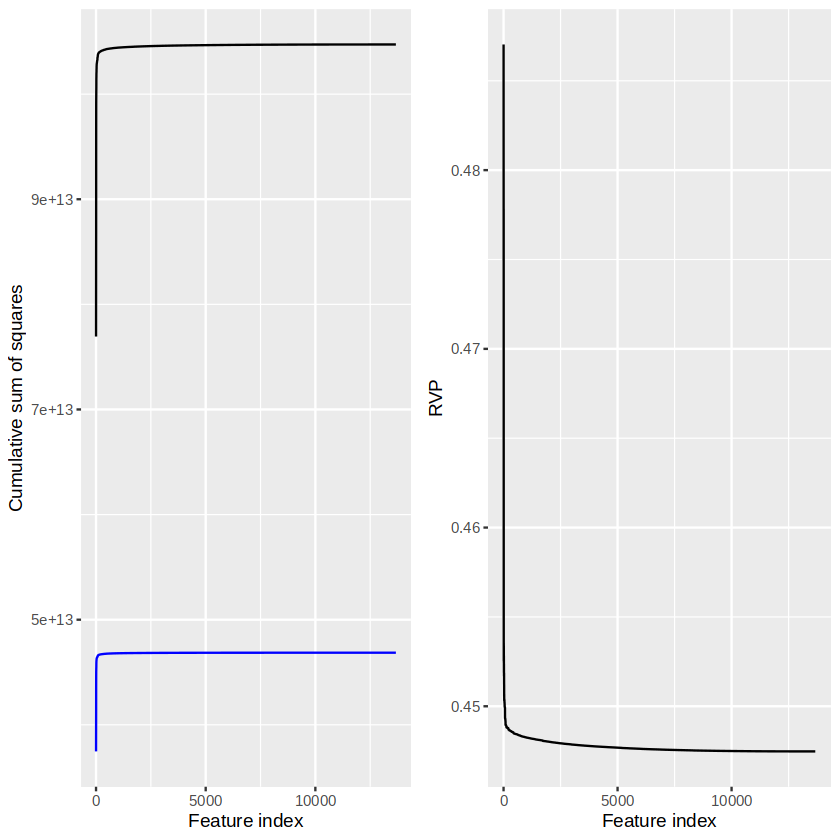

In [47]:
ax_rvp <- plot.rvp(SS_m10, cex = .5)
ax_rvp

In [48]:
file <- "~/Dropbox/tmp/ssm10-panc8.pdf"
ggsave(file, ax_rvp, width = 6, height = 3)

#### Plots

In [50]:
panc8_fltr <- ScaleData(panc8_fltr)

Centering and scaling data matrix



In [52]:
panc8_fltr <- RunPCA(panc8_fltr, features = rownames(panc8_fltr), npcs = 20)

PC_ 1 
Positive:  ERCC-00074, ERCC-00004, ERCC-00130, ERCC-00171, ERCC-00096, ERCC-00046, ERCC-00002, ERCC-00108, HNRPDL, ERCC-00113 
	   MTRNR2L1, C17orf76-AS1, ERCC-00003, MTRNR2L8, C22orf32, LSMD1, MRP63, ERCC-00042, ERCC-00009, ERCC-00043 
	   ERCC-00060, MTRNR2L2, EFHA1, MLL5, SC5DL, MLL, LOC550643, ERCC-00111, MLL3, KLHDC5 
Negative:  SERF2, SRP14, GABARAP, HINT1, COX4I1, COX7C, RPL8, TMBIM6, CD63, YWHAE 
	   RPL30, RPL31, MYL6, COX6C, PARK7, RPS11, SSR4, RPS14, RPL27, ATP6V0E1 
	   NDUFS5, RPLP1, PFDN5, COX6A1, SNRPD2, CALM2, COX7A2, NDUFB4, SOD1, EIF1 
PC_ 2 
Positive:  TCEB2, LOC284889, ATP5G2, ATP5J2, MIR6850, USMG5, ATP5L, ATPIF1, RPS14P3, ATP5I 
	   NACA2, ATP5A1, MRPS21, ATP5G3, ATP5H, PSMB3, ATP5EP2, C14orf2, ATP5E, SKP1P2 
	   GNB2L1, ATP5B, ATP5C1, CFL1, TMEM66, ATP6V0C, ATP5D, FAM127A, ATP5O, ATP5F1 
Negative:  AC087473.1, MIPOL1, TMEM45A, SAG, ASTN2, LINC00504, MEFV, KIAA1328, ADAMTSL3, CRX 
	   LINC02202, CYSLTR1, LINC02503, AC011453.1, TMEM212, LINC01609, CFAP54, AC

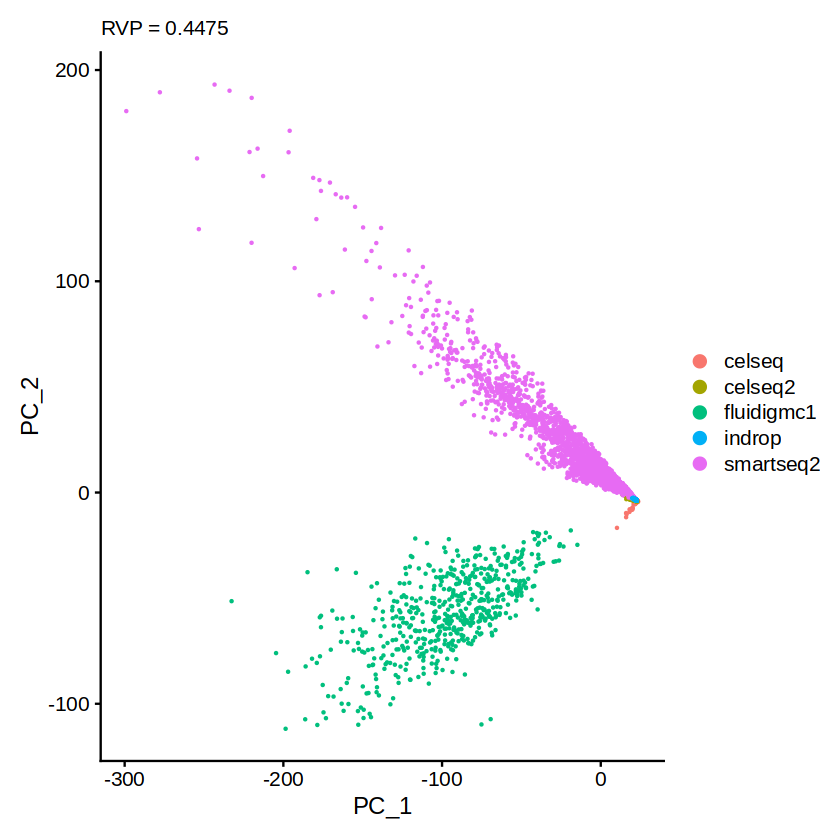

In [57]:
ax_pca <- DimPlot(panc8_fltr) +
  labs(subtitle = sprintf("RVP = %.4f", rvp$percentage))
ax_pca
file <- '~/Dropbox/tmp/pca-panc8_fltr.pdf'
ggsave(file, ax_pca, width = 6, height = 4)

In [58]:
panc8_fltr <- RunUMAP(panc8_fltr, dims = 1:20)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
02:43:22 UMAP embedding parameters a = 0.9922 b = 1.112

02:43:22 Read 7515 rows and found 20 numeric columns

02:43:22 Using Annoy for neighbor search, n_neighbors = 30

02:43:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:43:23 Writing NN index file to temp file /tmp/Rtmp0F6CaJ/file31e851faaba7

02:43:23 Searching Annoy index using 1 thread, search_k = 3000

02:43:25 Annoy recall = 100%

02:43:25 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

In [62]:
head(panc8_fltr@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,tech,replicate,assigned_cluster,celltype,dataset,pct_mito
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
D101_5,D101,4587.751,1959,celseq,celseq,NA,gamma,celseq,0
D101_7,D101,28806.188,4124,celseq,celseq,NA,acinar,celseq,0
D101_10,D101,6679.794,2382,celseq,celseq,NA,alpha,celseq,0
D101_13,D101,8745.098,2918,celseq,celseq,NA,delta,celseq,0
D101_14,D101,4996.479,2230,celseq,celseq,NA,beta,celseq,0
D101_17,D101,13339.853,3912,celseq,celseq,NA,ductal,celseq,0


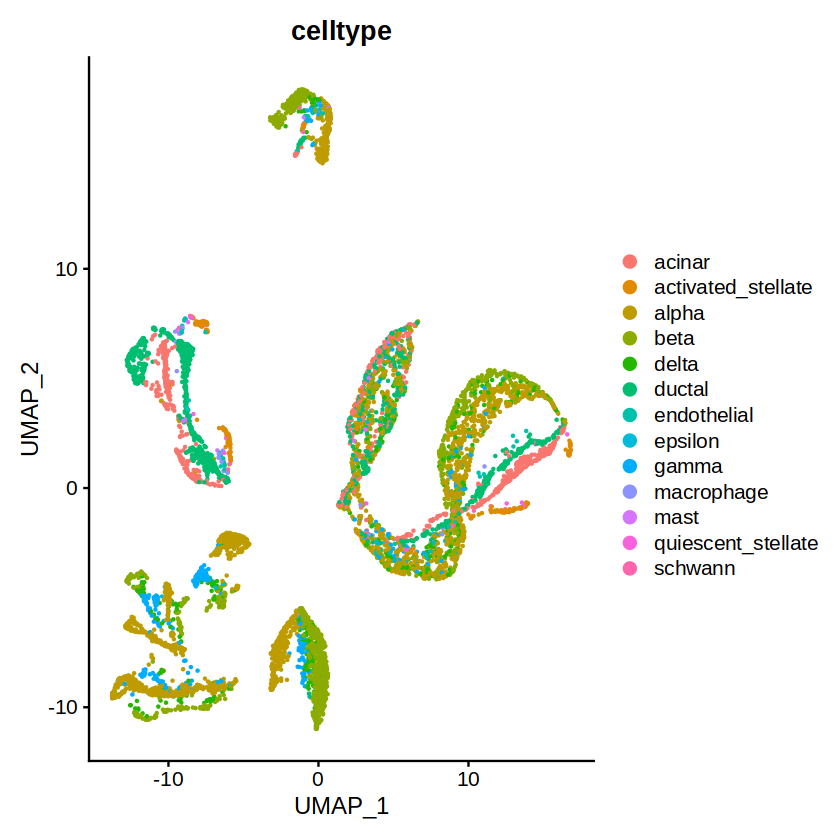

In [63]:
ax_umap <- DimPlot(panc8_fltr, reduction = "umap", group.by = "celltype")
ax_umap

In [64]:
file <- '~/Dropbox/tmp/umap_celltype-panc8_fltr.pdf'
ggsave(file, ax_umap, width = 6, height = 4)